# MMAI845 Tic Tac Toe / Connect 4 Project
## Game Board 5x6 4 to connect w/ gravity (i.e. Connect 4 with one less column and row)
## Team Humphrey | MMAI 2020

In [1]:
# Import libararies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import pickle
import sys
from time import time

In [2]:
# For nicer display - Mac's only - do not run on Windows (or change from Menlo to Courier New)

In [1]:
%%html
<style>
div.output pre {
font-family: Courier New;
}
</style>

In [4]:
# Board class - handles game board and game state
class Board:
    
    def __init__(self, board_size_row=3, board_size_col=3, connect_count=3):
        
        assert board_size_row >= 3 # Min: 3
        assert board_size_col >= 3 # Min: 3 
        assert connect_count <= board_size_row or connect_count <= board_size_col  # Otherswise no win possible
        
        # Set board size params
        self.board_size_row = board_size_row
        self.board_size_col = board_size_col
        self.board_size = self.board_size_row * self.board_size_col
        self.connect_count = connect_count
        
        self.reset()

    def reset(self):
        # Create empty board, initial state
        self.load_state(0, init=True) 
        return
    
    def place_move(self, r, c, p):
        
        assert self.game_state == 0 # Game is still in progress
        assert r in range(self.board_size_row) # r outside board
        assert c in range(self.board_size_col) # c outside board
        assert abs(p)==1 # Wrong value for p (-1 or 1 only)
        assert p == self.next_move   # Wrong player
        assert self.board[r, c] == 0 # Tried to place in non-empty slot

        self.board[r, c] = p   # put move on board
        self.total_slots -= 1  # decrease available slots by 1
        self.next_move *= -1   # change turn to next player
        self.turns += 1        # increase turns taken by 1
        
        # Check for end-game state
        self.game_state = self.check_winner()
        
        return True
    
    def check_winner(self):
        
        # Determine maximum square count top left corner
        con_row_max_r = self.board_size_row - self.connect_count + 1
        con_row_max_c = self.board_size_col - self.connect_count + 1

        for r in range(con_row_max_r):
            for c in range(con_row_max_c):

                # Check square of size connect_count x connect_count from board
                square = self.board[r:r+self.connect_count, c:c+self.connect_count]
                
                # Check if diagonal is winner
                s = np.sum(np.diagonal(square))
                if s == -self.connect_count: return -1
                if s == self.connect_count: return 1
                
                # Check if diagonal flipped is winner
                s = np.sum(np.diagonal(np.fliplr(square)))
                if s == -self.connect_count: return -1
                if s == self.connect_count: return 1
                
                # check if any row is winner
                if min(square.sum(axis = 0)) == -self.connect_count: return -1
                if max(square.sum(axis = 0)) == self.connect_count: return 1

                # check if any column is winner
                if min(square.sum(axis = 1)) == -self.connect_count: return -1
                if max(square.sum(axis = 1)) == self.connect_count: return 1
        
        if self.total_slots == 0:
            return 2 # Board full and nobody won ==> tie
        else:
            return 0 # No winning combinations
    
#     # standard tic-tac-toe
#     def valid_moves(self):
#         return 1*(self.board == 0)    # 1* is used to convert True/Flase to 1/0
    
    # connect-4 style / "gravity" (valid postions are most bottom position on each row)
    def valid_moves(self):
        v = 1*(self.board == 0)
        v2 = v * 0
        p = np.arange(1, board_size_row+1)
        for c in range(board_size_col):
            free_r = max(p * v[:, c]) - 1
            if free_r >= 0: v2[free_r, c] = 1        
        return v2
    
    def display(self):

        def XorO(b):
            d = "X O"
            return d[b + 1]
        
        print("\n")
        
        top1 = "   "
        for c in range(self.board_size_col):
            top1 += " " + str(c) + "  "
            
        print(top1)
        
        border = "  " + "+---"*self.board_size_col + "+"
        
        for r in range(self.board_size_row):
           
            pop_row = str(r) + " "
            for c in range(self.board_size_col):
                pop_row = pop_row + "| " + XorO(self.board[r, c]) + " "

            pop_row +="|"
            print(border)
            print(pop_row)
            
        print(border)
            
    def display_stats(self):
        def XorOorTie(b):
            if b == -1:
                return "X"
            elif b == 0:
                return ""
            elif b == 1:
                return "O"
            else:
                return "Tie"
        
        print("Next move: " + XorOorTie(self.next_move) 
              + " | Moves left: " + str(self.total_slots) 
              + " | Turns taken: " + str(self.turns)
              + " | Winner: " + XorOorTie(self.game_state)
             )
       
    def place_random_move(self):
        # get valid moves and multiply by random number
        v = self.valid_moves() * np.random.random((self.board_size_row, self.board_size_col))
        
        if self.game_state == 0:
            # chose highest random number r, c
            r = np.where(v == v.max())[0][0]
            c = np.where(v == v.max())[1][0]

            self.place_move(r, c, self.next_move)
            
            return True
        else:
            return False
        
    def is_game_on(self):
        return self.game_state == 0
    
    def return_state(self):
        s = self.board
        t = s.reshape(self.board_size) + 1   # add 1 to convert to terniary representation (i.e. -1 0 1 -> 0 1 2)
        o = self.board_size - 1 - np.arange(self.board_size) 
        u = np.sum((3**o)*t)   # convert to decimal number

        return u

    def return_state_next(self, r, c, p):
        s = self.board.copy()
        s[r, c] = p # place move
        t = s.reshape(self.board_size) + 1   # add 1 to convert to terniary representation (i.e. -1 0 1 -> 0 1 2)
        o = self.board_size - 1 - np.arange(self.board_size) 
        u = np.sum((3**o)*t)   # convert to decimal number

        return u
    
    def load_state(self, u, init=False):

        if init:
            self.board = np.zeros((self.board_size_row, self.board_size_col), dtype=np.byte)
        else:
            flat_board = np.zeros(self.board_size, dtype=np.byte)

            v = np.base_repr(u, 3)   # convert decimal to trinary
            v = "0"*(self.board_size - len(v)) + v  # pad with 0's to the left

            for i in range(len(v)): flat_board[i] = int(v[i]);   # put into flat array

            self.board = flat_board.reshape(self.board_size_row, self.board_size_col) - 1   # reshape to board dimensions, sub 1 (i.e. 0 1 2 -> -1 0 1)

        # Set proper game params
        if np.sum(self.board == 1) < np.sum(self.board == -1):   # O moves only when it has less than X
            self.next_move = 1
        else:
            self.next_move = -1
            
        self.total_slots = np.sum(self.board == 0)
        self.game_state = self.check_winner()       # -1 == X won, 0 == in progress, 1 == O won, 2 == game over and tie
        self.turns = np.sum(self.board != 0) # turns taken == number of non-empty tiles
        
        return 
    
    def play_game(self, AgentX, AgentO):

        while self.is_game_on():
            # Player X plays
            r, c = AgentX.get_move(self)  # self == board
            self.place_move(r, c, -1)
            
            
            # Player O plays if game still on
            if self.is_game_on():
                r, c = AgentO.get_move(self)   # self == board
                self.place_move(r, c, 1)
                
    def play_game_vs_human(self, AgentX, AgentO):
        
        while self.is_game_on():
            # Display the board and stats
            self.display()
            self.display_stats()
        
            # Player X plays
            r, c = AgentX.get_move(self)  # self == board
            self.place_move(r, c, -1)
            
            # Display the board and stats
            self.display()
            self.display_stats()
        
            # Player O plays if game still on
            if self.is_game_on():
                r, c = AgentO.get_move(self)   # self == board
                self.place_move(r, c, 1)
                
        # Display the board and stats
        self.display()
        self.display_stats()
        
    def play_game_n_rounds(self, AgentX, AgentO, rounds):
        
        winners = []
        
        for i in range(rounds):
            # Reset board
            self.reset()
            
            # Reset agents
            AgentX.reset()
            AgentO.reset() 
            
            self.play_game(AgentX, AgentO)
            
            winners.append(self.game_state)
        
        return winners
    
    def train(self, AgentX, AgentO, rounds=1):
        
        for i in range(rounds):
            # Reset board
            self.reset()

            # Reset agents
            AgentX.reset()
            AgentO.reset() 

            while self.is_game_on():
                # Player X plays
                r, c = AgentX.get_move(self)
                self.place_move(r, c, -1)
                AgentX.add_state(self.return_state())

                # Player O plays if game still on
                if self.is_game_on():
                    r, c = AgentO.get_move(self)
                    self.place_move(r, c, 1)
                    AgentO.add_state(self.return_state())

            # Assign the rewards
            if self.game_state == -1:
                AgentX.reward(1.0)
                AgentO.reward(-1.0)

            if self.game_state == 1:
                AgentX.reward(-1.0)
                AgentO.reward(1.0)

            if self.game_state == 2:
                AgentX.reward(0)
                AgentO.reward(0)


In [9]:
class AgentXO():
    def __init__(self, name, p, board_size_row=3, board_size_col=3, connect_count=3):
        
        assert abs(p) == 1   # player is -1 or 1 
        
        # Set agent params
        self.name = name
        self.p = p
        self.disc_fact = 0.99  # discount factor
        self.learn_rate = 0.30 # learning rate
        self.epsilon = 0.30    # epsilon
        
        # Set board size params, i.e. agent needs to know what kind of board it is playing with
        self.board_size_row = board_size_row
        self.board_size_col = board_size_col
        self.board_size = self.board_size_row * self.board_size_col
        self.connect_count = connect_count

        # How many moves in the round had to be guesses (where greedy)
        self.unknown_moves = 0
        
        # States list
        self.states = []
        
        # Value/states (i.e. main memory)
        self.states_values = {}

        # How many rounds agent trained for (counter)
        self.trained_rounds = 0
        
    def reset(self):
        # States list
        self.states = []
 
        # How many moves in the round had to be guesses (where greedy)
        self.unknown_moves = 0
        
    def get_move_random(self, board):
            valid_moves = board.valid_moves()
            
            # get valid moves and multiply by random number
            v = valid_moves * np.random.random((self.board_size_row, self.board_size_col))

            # chose highest random number r, c
            r = np.where(v == v.max())[0][0]
            c = np.where(v == v.max())[1][0]

            return r, c     
        
    def get_move(self, board):
        # Greedy vs exploratory
        if np.random.random() < self.epsilon:   # exploratory %
            r, c = self.get_move_random(board)
            return r, c 
        
        else:   # greedy
            best_value = -1000000
            best_r = -1
            best_c = -1

            current_state = board.return_state()
            valid_moves = board.valid_moves()
            found_one = False
            
            # Evaluate all positions, chose best next state with best value
            for r in range(self.board_size_row):
                for c in range(self.board_size_col):
                    if valid_moves[r, c] == 1:
                    
                        next_state = board.return_state_next(r, c, self.p)
                        if next_state in self.states_values:
                            next_value = self.states_values[next_state]
                            found_one = True
                        else:
                            # Move not on the list - what to do?
                            next_value = 0   # asume 0 for position
                            
                        if next_value > best_value:
                            best_r = r
                            best_c = c
                            best_value = next_value
            
            # no best move found
            if found_one == False:
                self.unknown_moves += 1 
                # if we don't find a best move, go random
                best_r, best_c = self.get_move_random(board)
                
            return best_r, best_c
        
    def add_state(self, state):
        self.states.append(state)
        
    def save_data(self):
        filename = self.name + str(self.board_size_row) + str(board_size_col) + str(self.connect_count) + "_" + str(self.trained_rounds) + ".pickle"
        
        pickle.dump(self.states_values, open(filename, "wb"))

    def load_data(self, filename, trained_rounds):
        self.reset()
        
        self.states_values = pickle.load(open(filename, "rb"))
        self.trained_rounds = trained_rounds
          
    def reward(self, r):  
        self.my_reward = r
        self.update_states_values(r)
        self.trained_rounds += 1
                  
    def update_states_values(self, r):       
        R = r
        
        # Set up states_values to default = 0
        for state in self.states: 
            if state not in self.states_values: self.states_values[state] = 0
                
        # Go through all the current game states, in reverse order
        for state in reversed(self.states):
            R *= self.disc_fact
            self.states_values[state] = self.states_values[state] + self.learn_rate * (R - self.states_values[state])
            R = self.states_values[state]    # Save R for next step
        

In [6]:
class Agent_Human():
    def __init__(self, name, p, board_size_row=3, board_size_col=3, connect_count=3):
        
        assert abs(p) == 1   # player is -1 or 1 
        
        # Set agent params
        self.name = name
        self.p = p
        
        # Set board size params, i.e. agent needs to know what kind of board it is playing with
        self.board_size_row = board_size_row
        self.board_size_col = board_size_col
        self.board_size = self.board_size_row * self.board_size_col
        self.connect_count = connect_count
        
    def reset(self):
        pass
        
    def get_move(self, board):

        valid_moves = board.valid_moves()
        valid_move = False
        
        while valid_move == False:
            print("\nYour turn. Rows [0 to " + str(self.board_size_row-1) +"] | Cols [0 to " + str(self.board_size_col-1) + "]" )
            print("")
            r = int(input("Row: "))
            c = int(input("Col: "))
            
            if r not in range(self.board_size_row) or c not in range(self.board_size_col):
                print("Invalid move. Try again.\n")
                
            elif valid_moves[r, c] != 1 :
                print("Invalid move. Try again.\n")
                
            else:
                valid_move = True
        
        return r, c

    def reward(self, r):  
        pass
            

In [10]:
# Train players - setup train/test loop
# -------------------------------------

# Board parameters
board_size_row=5
board_size_col=6
connect_count=4

# Train parameters
train_batch_games = 100000   # 1 game = 1 episode
train_epsilon = [0.30, 0.20, 0.10, 0.05]

# Test (i.e. play) parameters
play_batch_games = 1000
test_epsilon = 0 

# Train / test parameters
train_test_rounds = 1 # 1 round = train_batch_games, followed by play_batch_games
current_round = 0

# Setup statistics
current_round = 0
round_n = []
train_rounds = []
test_rounds = []

# stats vs O player epsilon - array of dictionary
X_wins = []
O_wins = []
ties = []


# Create board
board = Board(board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)

# Create agents
X = AgentXO(name = "Agent X", p=-1, board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)
O = AgentXO(name = "Agent O", p= 1, board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)


In [39]:
train_test_rounds = 100


In [40]:
for r in range(current_round, current_round + train_test_rounds):
    
    current_round += 1
    
    print("")
    print("-"*100)
    print("Round: " +str(r))
    print("-"*100)
    
    # Train agents (incrementally)
    # ----------------------------
    
    X.epsilon = train_epsilon[(current_round-1) % 4]
    O.epsilon = train_epsilon[(current_round-1) % 4]

    print("Starting training")
    print(f"X epsilon = {X.epsilon} | O epsilon = {O.epsilon}")
    
    start_time = time()
    board.train(AgentX = X, AgentO = O, rounds=train_batch_games)
    end_time = time()
    
    print("Training completed in: " +  str(end_time - start_time) + " secs")
    print("X - trained rounds:    ", X.trained_rounds)
    print("X - # of states_values:", len(X.states_values))
    print("O - # of states_values:", len(O.states_values))    
    
    
    
    # Test how good agents are playing at latest cumulative training level
    # --------------------------------------------------------------------
    
    X.epsilon = 0
    e_range = [0, 0.10, 0.50, 0.99]
    
    X_wins_e = []
    O_wins_e = []
    ties_e = []
    
    print("")
    print("Starting testing")
    
    # Play the games - vs O epsilon = 0, 0.10, 0.50, 0.99
    start_time = time()
    for e in e_range:
        O.epsilon = e 
        winners = board.play_game_n_rounds(X, O, rounds=play_batch_games)

        # Record winning stats
        game_X_win = np.sum(np.array(winners) == -1)
        game_O_win = np.sum(np.array(winners) == 1)
        game_tied = np.sum(np.array(winners) == 2)
        
        X_wins_e.append(game_X_win)
        O_wins_e.append(game_O_win)
        ties_e.append(game_tied)
    
        # Display winning stats
        print("Vs. O epsilon = " + str(e) + " | Games played: " + str(play_batch_games) + " | X wins:" + str(game_X_win) + " | O wins:" + str(game_O_win) + " | Tied games:" + str(game_tied) )
        
    end_time = time()
    
    X_wins.append(X_wins_e)
    O_wins.append(O_wins_e)
    ties.append(ties_e)

    print("")
    print("Testing completed in: " +  str(end_time - start_time) + " secs")
    

    # Save statistics
    round_n.append(r)
    train_rounds.append(train_batch_games)
    test_rounds.append(play_batch_games)




----------------------------------------------------------------------------------------------------
Round: 200
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.3 | O epsilon = 0.3
Training completed in: 785.8996932506561 secs
X - trained rounds:     20100000
X - # of states_values: 58518929
O - # of states_values: 59658734

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:0 | O wins:1000 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:293 | O wins:619 | Tied games:88
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:826 | O wins:116 | Tied games:58
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:984 | O wins:13 | Tied games:3

Testing completed in: 26.357344150543213 secs

----------------------------------------------------------------------------------------------------
Round: 201
------------------------------------------------------------------------------------

Training completed in: 934.9943337440491 secs
X - trained rounds:     21100000
X - # of states_values: 60640164
O - # of states_values: 61823272

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:1000 | O wins:0 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:686 | O wins:57 | Tied games:257
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:800 | O wins:105 | Tied games:95
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:981 | O wins:16 | Tied games:3

Testing completed in: 31.028079748153687 secs

----------------------------------------------------------------------------------------------------
Round: 211
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.05 | O epsilon = 0.05
Training completed in: 976.9821226596832 secs
X - trained rounds:     21200000
X - # of states_values: 60852012
O - # of states_values: 62041619

Starting testing
Vs. O epsilon = 0 | Games played

Vs. O epsilon = 0 | Games played: 1000 | X wins:1000 | O wins:0 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:802 | O wins:149 | Tied games:49
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:882 | O wins:89 | Tied games:29
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:984 | O wins:14 | Tied games:2

Testing completed in: 23.707709312438965 secs

----------------------------------------------------------------------------------------------------
Round: 221
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.2 | O epsilon = 0.2
Training completed in: 847.1805312633514 secs
X - trained rounds:     22200000
X - # of states_values: 62953452
O - # of states_values: 64179156

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:490 | O wins:510 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:553 | O wins:383 | Tied games:64
Vs. O epsilon = 0.5 | Games played:

Vs. O epsilon = 0.5 | Games played: 1000 | X wins:821 | O wins:128 | Tied games:51
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:987 | O wins:12 | Tied games:1

Testing completed in: 30.279911279678345 secs

----------------------------------------------------------------------------------------------------
Round: 231
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.05 | O epsilon = 0.05
Training completed in: 1009.3134179115295 secs
X - trained rounds:     23200000
X - # of states_values: 65002701
O - # of states_values: 66271563

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:366 | O wins:367 | Tied games:267
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:517 | O wins:233 | Tied games:250
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:815 | O wins:102 | Tied games:83
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:985 | O wins:12 | Tied games:3

Testing completed in: 70

Training completed in: 849.462316274643 secs
X - trained rounds:     24200000
X - # of states_values: 67052022
O - # of states_values: 68354928

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:1000 | O wins:0 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:889 | O wins:56 | Tied games:55
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:890 | O wins:80 | Tied games:30
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:991 | O wins:8 | Tied games:1

Testing completed in: 26.413164138793945 secs

----------------------------------------------------------------------------------------------------
Round: 242
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.1 | O epsilon = 0.1
Training completed in: 927.7763204574585 secs
X - trained rounds:     24300000
X - # of states_values: 67251789
O - # of states_values: 68560195

Starting testing
Vs. O epsilon = 0 | Games played: 1000

Vs. O epsilon = 0.1 | Games played: 1000 | X wins:513 | O wins:409 | Tied games:78
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:784 | O wins:161 | Tied games:55
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:987 | O wins:11 | Tied games:2

Testing completed in: 28.521016120910645 secs

----------------------------------------------------------------------------------------------------
Round: 252
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.3 | O epsilon = 0.3
Training completed in: 783.5057466030121 secs
X - trained rounds:     25300000
X - # of states_values: 69242920
O - # of states_values: 70591064

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:704 | O wins:233 | Tied games:63
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:687 | O wins:226 | Tied games:87
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:877 | O wins:74 | Tied games:49
Vs. O epsilon = 0.99 | Games p

Vs. O epsilon = 0.99 | Games played: 1000 | X wins:984 | O wins:14 | Tied games:2

Testing completed in: 26.063191413879395 secs

----------------------------------------------------------------------------------------------------
Round: 262
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.1 | O epsilon = 0.1
Training completed in: 966.088770866394 secs
X - trained rounds:     26300000
X - # of states_values: 71174624
O - # of states_values: 72557616

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:1000 | O wins:0 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:779 | O wins:91 | Tied games:130
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:865 | O wins:72 | Tied games:63
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:992 | O wins:6 | Tied games:2

Testing completed in: 27.40809726715088 secs

-----------------------------------------------------------------------

Training completed in: 788.2094712257385 secs
X - trained rounds:     27300000
X - # of states_values: 73075180
O - # of states_values: 74493331

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:875 | O wins:67 | Tied games:58
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:748 | O wins:174 | Tied games:78
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:840 | O wins:119 | Tied games:41
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:977 | O wins:20 | Tied games:3

Testing completed in: 27.540989875793457 secs

----------------------------------------------------------------------------------------------------
Round: 273
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.2 | O epsilon = 0.2
Training completed in: 878.5638864040375 secs
X - trained rounds:     27400000
X - # of states_values: 73263649
O - # of states_values: 74684074

Starting testing
Vs. O epsilon = 0 | Games played:

Vs. O epsilon = 0.1 | Games played: 1000 | X wins:410 | O wins:108 | Tied games:482
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:914 | O wins:54 | Tied games:32
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:990 | O wins:7 | Tied games:3

Testing completed in: 27.819395542144775 secs

----------------------------------------------------------------------------------------------------
Round: 283
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.05 | O epsilon = 0.05
Training completed in: 968.3795394897461 secs
X - trained rounds:     28400000
X - # of states_values: 75152835
O - # of states_values: 76611790

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:720 | O wins:189 | Tied games:91
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:666 | O wins:229 | Tied games:105
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:872 | O wins:83 | Tied games:45
Vs. O epsilon = 0.99 | Games

Vs. O epsilon = 0.99 | Games played: 1000 | X wins:996 | O wins:2 | Tied games:2

Testing completed in: 27.55433225631714 secs

----------------------------------------------------------------------------------------------------
Round: 293
----------------------------------------------------------------------------------------------------
Starting training
X epsilon = 0.2 | O epsilon = 0.2
Training completed in: 859.0842957496643 secs
X - trained rounds:     29400000
X - # of states_values: 77023654
O - # of states_values: 78510741

Starting testing
Vs. O epsilon = 0 | Games played: 1000 | X wins:1000 | O wins:0 | Tied games:0
Vs. O epsilon = 0.1 | Games played: 1000 | X wins:867 | O wins:83 | Tied games:50
Vs. O epsilon = 0.5 | Games played: 1000 | X wins:894 | O wins:68 | Tied games:38
Vs. O epsilon = 0.99 | Games played: 1000 | X wins:987 | O wins:12 | Tied games:1

Testing completed in: 26.195032119750977 secs

-----------------------------------------------------------------------

In [41]:
# Save agent's memory
# -------------------
X.save_data()
O.save_data()

In [11]:
# Load agent's memory
# -------------------
X.load_data("Agent X564_30000000.pickle", 30000000)
O.load_data("Agent O564_30000000.pickle", 30000000)

In [42]:
# Save statistics
# ---------------
pickle.dump(X_wins, open("X_wins B5x6 4cg_30000000", "wb"))
pickle.dump(O_wins, open("O_wins B5x6 4cg_30000000", "wb"))
pickle.dump(ties, open("ties_B5x6 4cg_30000000", "wb"))
pickle.dump(round_n, open("round_n B5x6 4cg_30000000", "wb"))

In [ ]:
# Load statistics
# ---------------
X_wins = pickle.load(open("X_wins B5x6 4cg_30000000", "rb"))
O_wins = pickle.load(open("O_wins B5x6 4cg_30000000", "rb"))
ties = pickle.load(open("ties_B5x6 4cg_30000000", "rb"))
round_n = pickle.load(open("round_n B5x6 4cg_30000000", "rb"))

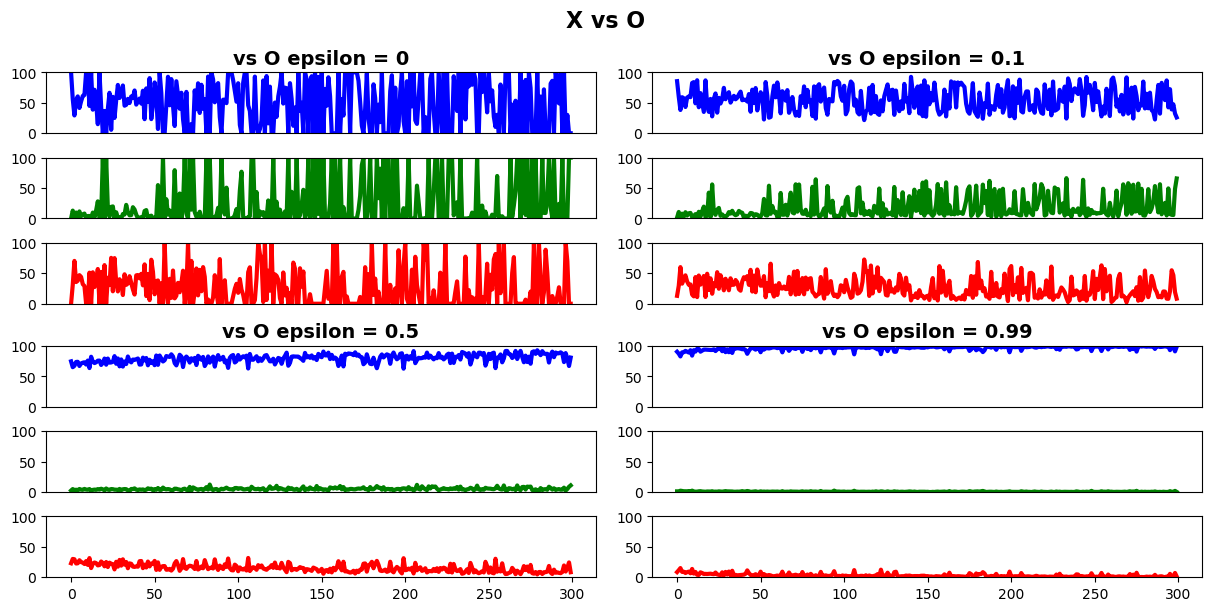

In [43]:
# Graph statistics
# ----------------
plt.style.use('default')
f, axarr = plt.subplots(6, 2, constrained_layout=True, figsize=(12,6))

#axarr.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

f.suptitle("X vs O", fontsize=16, fontweight="bold")

rows = [0, 0, 3, 3]
cols = [0, 1, 0, 1]

for i in range(4):
    row = rows[i]
    col = cols[i]
    axarr[row, col].set_title("vs O epsilon = " + str(e_range[i]), fontsize=14, fontweight="bold")
    axarr[row, col].plot(np.array(round_n), np.array(X_wins)[:,i] / 10, linewidth=3, color="blue")
    axarr[row, col].axes.get_xaxis().set_visible(False)
    axarr[row, col].axes.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axarr[row, col].set_ylim([0, 100])
    
    row = rows[i] + 1
    col = cols[i]
    axarr[row, col].plot(np.array(round_n), np.array(ties)[:,i] / 10, linewidth=3, color="green")
    axarr[row, col].axes.get_xaxis().set_visible(False)
    axarr[row, col].axes.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axarr[row, col].set_ylim([0, 100])
    
    row = rows[i] + 2
    col = cols[i]
    axarr[row, col].plot(np.array(round_n), np.array(O_wins)[:,i] / 10, linewidth=3, color="red")
    axarr[row, col].axes.get_xaxis().set_visible(False)
    axarr[row, col].axes.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axarr[row, col].set_ylim([0, 100])

# Make the bottom x-axis visible
axarr[5, 0].axes.get_xaxis().set_visible(True)
axarr[5, 1].axes.get_xaxis().set_visible(True)

#plt.legend(loc='upper left')

plt.show()

In [19]:
## Test how good Agent X is against humans (as O)
# ----------------------------------------------

# Create a new board
board = Board(board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)

# Create human agent
Human_O = Agent_Human(name = "Agent O", p= 1, board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)

# Run game to completion
X.epsilon = 0
board.play_game_vs_human(X, Human_O)



    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
2 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
3 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
4 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
Next move: X | Moves left: 30 | Turns taken: 0 | Winner: 


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
2 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
3 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
4 |   |   |   | X |   |   |
  +---+---+---+---+---+---+
Next move: O | Moves left: 29 | Turns taken: 1 | Winner: 

Your turn. Rows [0 to 4] | Cols [0 to 5]

Row: 4
Col: 2


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+--

Row: 4
Col: 4


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   | X | X |   |   |
  +---+---+---+---+---+---+
1 | O |   | O | O |   | X |
  +---+---+---+---+---+---+
2 | X |   | X | X |   | O |
  +---+---+---+---+---+---+
3 | O |   | X | O |   | X |
  +---+---+---+---+---+---+
4 | O | X | O | X | O | O |
  +---+---+---+---+---+---+
Next move: X | Moves left: 10 | Turns taken: 20 | Winner: 


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   | X | X |   |   |
  +---+---+---+---+---+---+
1 | O |   | O | O |   | X |
  +---+---+---+---+---+---+
2 | X |   | X | X |   | O |
  +---+---+---+---+---+---+
3 | O |   | X | O | X | X |
  +---+---+---+---+---+---+
4 | O | X | O | X | O | O |
  +---+---+---+---+---+---+
Next move: O | Moves left: 9 | Turns taken: 21 | Winner: 

Your turn. Rows [0 to 4] | Cols [0 to 5]

Row: 0
Col: 0


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 | O |   | X | X |   |   |
  +---+---+---+---+---+---+
1 | O |   | O | O |   

In [18]:
X.unknown_moves

0

In [45]:
#### Test how good Agent X is against humans (as X)
# ----------------------------------------------

# Create a new board
board = Board(board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)

# Create human agent
Human_X = Agent_Human(name = "Agent X", p= -1, board_size_row=board_size_row, board_size_col=board_size_col, connect_count=connect_count)

# Run game to completion
O.epsilon = 0
board.play_game_vs_human(Human_X, O)



    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
2 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
3 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
4 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
Next move: X | Moves left: 30 | Turns taken: 0 | Winner: 

Your turn. Rows [0 to 4] | Cols [0 to 5]

Row: 4
Col: 3


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
2 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
3 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
4 |   |   |   | X |   |   |
  +---+---+---+---+---+---+
Next move: O | Moves left: 29 | Turns taken: 1 | Winner: 


    0   1   2   3   4   5  
  +---+---+---+---+---+---+
0 |   |   |   |   |   |   |
  +---+---+---+---+---+---+
1 |   |   |   |   |   |   |
  +---+--

In [31]:
O.unknown_moves

0